In [1]:
%matplotlib inline
# We'll start with our library imports...
from __future__ import print_function

import numpy as np                 # to use numpy arrays
import tensorflow as tf            # to specify and run computation graphs
import tensorflow_datasets as tfds # to load training data
import matplotlib.pyplot as plt    # to visualize data and draw plots
from tqdm import tqdm              # to track progress of loops

DATA_DIR = './tensorflow-datasets/'

2023-02-03 22:36:03.235820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2023-02-03 22:36:03.235859: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-03 22:36:03.235886: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c0302.crane.hcc.unl.edu): /proc/driver/nvidia/version does not exist
2023-02-03 22:36:03.236247: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 22:36:03.316587: I tensorflow/compiler/mlir/mlir_graph_opti

data shape: (32, 28, 28, 1)
label: tf.Tensor([1 8 7 8 5 9 5 6 4 3 4 2 1 2 0 5 8 1 1 8 1 6 7 6 6 4 1 8 4 3 1 6], shape=(32,), dtype=int64)
An image looks like this:
It's colored because matplotlib wants to provide more contrast than just greys


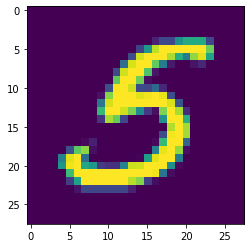

In [2]:
ds = tfds.load('mnist', data_dir=DATA_DIR, shuffle_files=True) # this loads a dict with the datasets

# We can create an iterator from each dataset
# This one iterates through the train data, shuffling and minibatching by 32
train_ds = ds['train'].shuffle(1024).batch(32)

# Looping through the iterator, each batch is a dict
for batch in train_ds:
    # The first dimension in the shape is the batch dimension
    # The second and third dimensions are height and width
    # Being greyscale means that the image has one channel, the last dimension in the shape
    print("data shape:", batch['image'].shape)
    print("label:", batch['label'])
    break

# visualize some of the data
idx = np.random.randint(batch['image'].shape[0])
print("An image looks like this:")
imgplot = plt.imshow(batch['image'][idx])
print("It's colored because matplotlib wants to provide more contrast than just greys")

In [3]:
class Dense(tf.Module):
    def __init__(self, output_size, activation=tf.nn.relu):
        """
        Args:
            - output_size: (int) number of neurons
            - activation: (function) non-linear function applied to the output
        """
        self.output_size = output_size
        self.activation = activation
        self.is_built = False
        
    def _build(self, x):
        data_size = x.shape[-1]
        self.W = tf.Variable(tf.random.normal([data_size, self.output_size]), name='weights')
        self.b = tf.Variable(tf.random.normal([self.output_size]), name='bias')
        self.is_built = True

    def __call__(self, x):
        if not self.is_built:
            self._build(x)
        return self.activation(tf.matmul(x, self.W) + self.b)

100%|██████████| 1875/1875 [00:02<00:00, 640.44it/s]


Accuracy: 0.1067


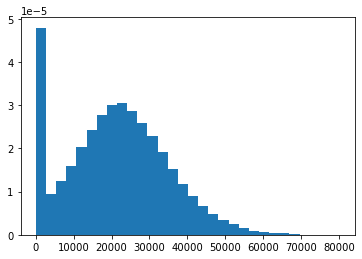

In [4]:
first_layer = Dense(200)
second_layer = Dense(10)

loss_values = []
accuracy_values = []
# Loop through one epoch of data
for batch in tqdm(train_ds):
    # run network
    x = tf.reshape(tf.cast(batch['image'], tf.float32), [-1, 784]) # -1 means everyting not otherwise accounted for
    labels = batch['label']
    x = first_layer(x)
    logits = second_layer(x)
    
    # calculate loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    loss_values.append(loss)
    
    # calculate accuracy
    predictions = tf.argmax(logits, axis=1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
    accuracy_values.append(accuracy)

# print accuracy
print("Accuracy:", np.mean(accuracy_values))
# plot per-datum loss
loss_values = np.concatenate(loss_values)
plt.hist(loss_values, density=True, bins=30)
plt.show()

# Model 1 with 2 added layers 50 and 100 layers

100%|██████████| 1875/1875 [00:12<00:00, 146.54it/s]


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (32, 200)                 157000    
_________________________________________________________________
dense_5 (Dense)              (32, 50)                  10050     
_________________________________________________________________
dense_6 (Dense)              (32, 100)                 5100      
_________________________________________________________________
dense_7 (Dense)              (32, 10)                  1010      
Total params: 173,160
Trainable params: 173,160
Non-trainable params: 0
_________________________________________________________________
None
Accuracy: 0.94465667


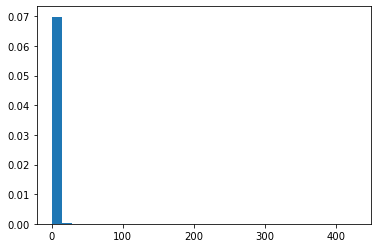

In [6]:
# using Sequential groups all the layers to run at once
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(200, tf.nn.relu))
model.add(tf.keras.layers.Dense(50))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(10))
optimizer = tf.keras.optimizers.Adam()

loss_values = []
accuracy_values = []
# Loop through one epoch of data
for epoch in range(10):
    for batch in tqdm(train_ds):
        with tf.GradientTape() as tape:
            # run network
            x = tf.reshape(tf.cast(batch['image'], tf.float32), [-1, 784])
            labels = batch['label']
            logits = model(x)

            # calculate loss
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)    
        loss_values.append(loss)
    
        # gradient update
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
        # calculate accuracy
        predictions = tf.argmax(logits, axis=1)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
        accuracy_values.append(accuracy)

print(model.summary())
    
# accuracy
print("Accuracy:", np.mean(accuracy_values))
# plot per-datum loss
loss_values = np.concatenate(loss_values)
plt.hist(loss_values, density=True, bins=30)
plt.show()

# Model 2 with different number of neurons

100%|██████████| 1875/1875 [00:08<00:00, 224.77it/s]


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (32, 10)                  7850      
_________________________________________________________________
dense_13 (Dense)             (32, 10)                  110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
None
Accuracy: 0.15553333


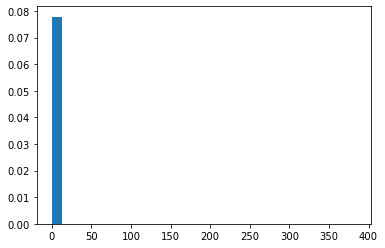

In [11]:
# using Sequential groups all the layers to run at once
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, tf.nn.relu))
model.add(tf.keras.layers.Dense(10))
optimizer = tf.keras.optimizers.Adam()

loss_values = []
accuracy_values = []
# Loop through one epoch of data
for epoch in range(2):
    for batch in tqdm(train_ds):
        with tf.GradientTape() as tape:
            # run network
            x = tf.reshape(tf.cast(batch['image'], tf.float32), [-1, 784])
            labels = batch['label']
            logits = model(x)

            # calculate loss
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)    
        loss_values.append(loss)
    
        # gradient update
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
        # calculate accuracy
        predictions = tf.argmax(logits, axis=1)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
        accuracy_values.append(accuracy)

print(model.summary())
    
# accuracy
print("Accuracy:", np.mean(accuracy_values))
# plot per-datum loss
loss_values = np.concatenate(loss_values)
plt.hist(loss_values, density=True, bins=30)
plt.show()

# Model 3 with different optimizer 

100%|██████████| 1875/1875 [00:14<00:00, 128.81it/s]


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (32, 200)                 157000    
_________________________________________________________________
dense_23 (Dense)             (32, 10)                  2010      
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
_________________________________________________________________
None
Accuracy: 0.8926333


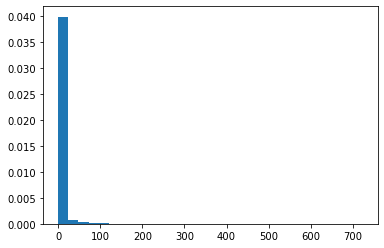

In [14]:
# using Sequential groups all the layers to run at once
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(200, tf.nn.relu))
model.add(tf.keras.layers.Dense(10))
optimizer = tf.keras.optimizers.RMSprop()

loss_values = []
accuracy_values = []
# Loop through one epoch of data
for epoch in range(1):
    for batch in tqdm(train_ds):
        with tf.GradientTape() as tape:
            # run network
            x = tf.reshape(tf.cast(batch['image'], tf.float32), [-1, 784])
            labels = batch['label']
            logits = model(x)

            # calculate loss
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)    
        loss_values.append(loss)
    
        # gradient update
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
        # calculate accuracy
        predictions = tf.argmax(logits, axis=1)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
        accuracy_values.append(accuracy)

print(model.summary())
    
# accuracy
print("Accuracy:", np.mean(accuracy_values))
# plot per-datum loss
loss_values = np.concatenate(loss_values)
plt.hist(loss_values, density=True, bins=30)
plt.show()

# Model 4 with train test split and early stopping 
